## Towed cars outside Info-Neige hours

This is the code used to find car towings that seemed to be outside of scheduled snow removal restricted times.

Three datasets were used in this research:

* [Cars towed by the city of Montreal since Nov. 2015](https://drive.google.com/file/d/1Vf_Nhk9-3mdx8qtgI7OufaY962j9L2wn/view?usp=sharing). Based on [Info-Remorquage data in the Montreal open data portal](http://donnees.ville.montreal.qc.ca/dataset/remorquages-de-vehicules-genants)
* [The double geobase](http://donnees.ville.montreal.qc.ca/dataset/geobase-double)
* [Historical Planif-Neige schedules](https://drive.google.com/file/d/1sfE2qFFaV0peJeu3kbPWtlpOm4EtsXoC/view?usp=sharing), compiled and contributed by Christophe Deprez, creator of [infoneige.ca](http://infoneige.ca/). These need to be unzipped.

Before doing the analysis in this notebook, towing records needed to be associated to a street ID number, which is how the Planif-Neige data is organized. Every street typically has two schedules per snow removal operation, one for each curbside. 

To do this, a spatial join was made in ArcGIS between the towing data and the double géobase, a spatial file with both edges of every street in Montreal. Each towing point was joined to the cloest street edge to assign it a street side ID.

The join operation gave each towing point a distance attibute from the street edge, in decimal degrees.

However, the geographic coordinates of towings cannot be assumed to be precise enough to link it to a street side. In the image below, red dots are towed cars and yellow lines are street edges.

![all towed cars map](img/all_cars.png)

As you can see, there are many points that are in the middle of the street and cannot be accurately linked to one side or the other.

So we need to assume that the car could have been towed from either side and see if they were inside the restricted hours of both.

This most likely undercounts the number of worngful towings but it's the best way to eliminate false positives.

### Analysis

Import libraries and set display options

In [1]:
import pandas as pd
import numpy as np
import geopandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)
%matplotlib inline

Load up and inspect car towing data that was spatially joined with the double geobase in ArcGIS. The key columns here are:

* COT_RUE_ID - unique ID of street side the towing record was joined to
* ID_TRC - unique ID of street segment car was towed from. This is the first 7 digits of COT_RUE_ID
* DATE_ORIGI - date and time the car was towed
* MOTIF_REMO - the reason for towing
* UID - unique ID of towing, generated in ArcGIS
* Distance - Distance of towing location to street side, in decimal degrees

This data wil be joined with the Planif-Neige data on the `COTE_RUE_ID` column, then checked to make sure the towing wasn't linked to the wrong side by checking snow-removal schedules on the opposite side.

In [2]:
cols = ['ARRONDISSE', 'COT_RUE_ID', 'DATE_ORIGI', 'Distance', 'ID_TRC', 'LATITUDE_O',
       'LONGITUDE_', 'MOTIF_REMO', 'NOM_VOIE', 'RUE_ORIGIN', 'SECTEUR_OR', 'UID', 'geometry']

towed = ( geopandas.read_file('input/nearest_road_segment_to_point.shp')
          .assign(DATE_ORIGI = lambda x: pd.to_datetime(x['DATE_ORIGI']) )
          .assign(COT_RUE_ID = lambda x: x['COT_RUE_ID'].astype(int).astype(str))
          .assign(ID_TRC = lambda x: x['ID_TRC'].astype(int).astype(str))
        )[cols]
towed = towed[towed.MOTIF_REMO == "Constat d'infraction"]

print('Number of towing records:')
print(len(towed))
towed.head()

Number of towing records:
129256


,ARRONDISSE,COT_RUE_ID,DATE_ORIGI,Distance,ID_TRC,LATITUDE_O,LONGITUDE_,MOTIF_REMO,NOM_VOIE,RUE_ORIGIN,SECTEUR_OR,UID,geometry
0,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,None,1,POINT (-73.6128095989 45.520778662)
1,Sud-Ouest,16003101,2015-12-30 08:54:00,0.00003,1600310,45.44807,-73.59343,Constat d'infraction,Raudot,rue Raudot,None,2,POINT (-73.5934295534 45.4480660717)
2,Villeray - Saint-Michel - Parc-Extension,11000341,2015-12-30 20:23:00,0.00001,1100034,45.55250,-73.61536,Constat d'infraction,Cartier,rue Cartier,None,3,POINT (-73.6153615132 45.5525021398)
3,Ville-Marie,13901481,2015-12-29 16:11:00,0.00001,1390148,45.52928,-73.56323,Constat d'infraction,Dorion,rue Dorion,None,4,POINT (-73.5632258421 45.5292784803)
4,Ahuntsic - Cartierville,10400101,2015-12-30 10:43:00,0.00000,1040010,45.55721,-73.63446,Constat d'infraction,André-Grasset,avenue André-Grasset,None,5,POINT (-73.6344620715 45.5572148768)


In [3]:
# Latest date in towed data

towed.DATE_ORIGI.sort_values().tail(1)

132430   2018-03-22 12:45:00
Name: DATE_ORIGI, dtype: datetime64[ns]

year
2015    Axes(0.125,0.125;0.775x0.755)
2016    Axes(0.125,0.125;0.775x0.755)
2017    Axes(0.125,0.125;0.775x0.755)
2018    Axes(0.125,0.125;0.775x0.755)
dtype: object

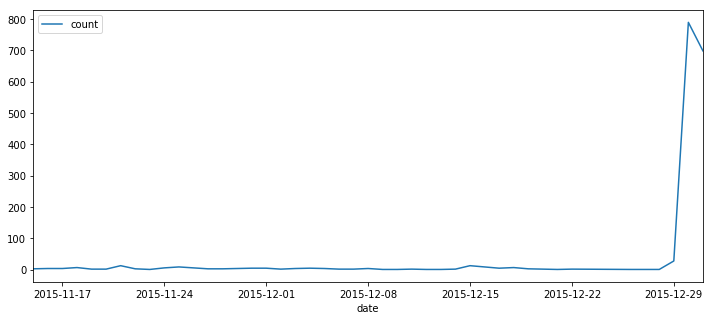

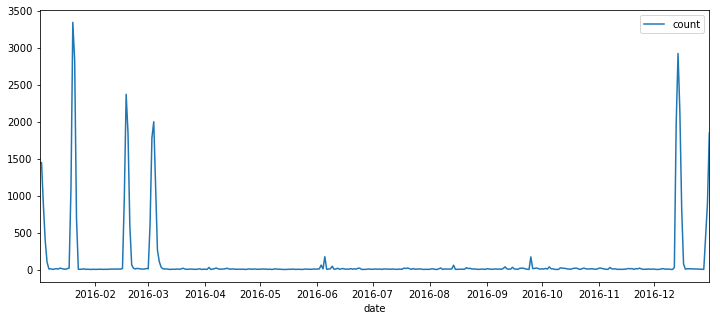

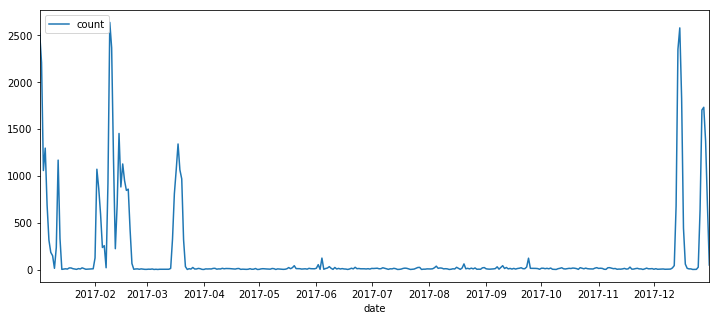

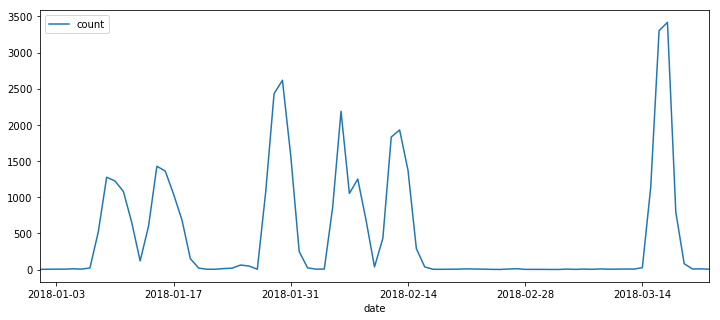

In [4]:
# See frequency of tows by year

by_year = towed.groupby([towed.DATE_ORIGI.dt.year, towed.DATE_ORIGI.dt.date]).size()
by_year.index.names = ['year', 'date']
by_year.reset_index().rename(columns = {0 : 'count'}).groupby('year').plot(x = 'date', y='count', figsize= (12, 5))

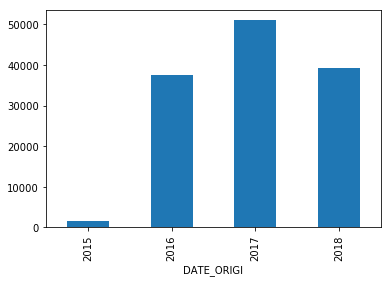

In [5]:
# Number of tows per year

towed.groupby(towed.DATE_ORIGI.dt.year).size().plot.bar()

Load and inspect historical Info-Neige schedules. Column descriptions and API specs [can be found here](http://donnees.ville.montreal.qc.ca/dataset/deneigement). The column `COTE_RUE_ID` will be the key column for joining to the towing data.

The code creates a time buffer column of 1 day before and after the scheduled snow removal. This will be the window in which we'll look for cars towed outside posted restriction hours. The larger this window, the more cars appear as being wrongfully towed. This is risky, because it can capture cars that were towed for reasons other than snow removal, so we're being conservative here.

But I have verified cars that were towed up to six days before a scheduled operation.

In [49]:
import glob

files = glob.glob('../Snow removal/Infoneige archive/infoneige.ca*.csv')
snow = []
for file in files:
    temp = pd.read_csv(file, dtype={'COTE_RUE_ID' : str, 'ETAT_DENEIG' : str}, parse_dates=[3,4,5,6,7])
    snow.append(temp)
snow = pd.concat(snow)
snow = snow[snow.DATE_DEB_PLANIF.notnull()]

# Create categorical coulumn for night vs. morning snow removal operations.
# This could be useful in visualization later
snow['shift'] = np.where(snow.DATE_DEB_PLANIF.dt.hour > 13, 'night', 'morning')

# Create a buffer time period, 1 day before operations start and 1 day after end,
# to see distribution on towing in and outside restriction hours
snow = (snow.assign(start_buffer = snow.DATE_DEB_PLANIF - pd.DateOffset(hours = 12))
            .assign(end_buffer = snow.DATE_FIN_PLANIF + pd.DateOffset(hours = 12)) 
       )

snow.dtypes

C:\Users\rochar\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2683: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MUNID                        object
COTE_RUE_ID                  object
ETAT_DENEIG                  object
DATE_DEB_PLANIF      datetime64[ns]
DATE_FIN_PLANIF      datetime64[ns]
DATE_DEB_REPLANIF    datetime64[ns]
DATE_FIN_REPLANIF    datetime64[ns]
DATE_MAJ             datetime64[ns]
shift                        object
start_buffer         datetime64[ns]
end_buffer           datetime64[ns]
dtype: object

Inspect a random sample of records

In [50]:
snow.sample(6)

,MUNID,COTE_RUE_ID,ETAT_DENEIG,DATE_DEB_PLANIF,DATE_FIN_PLANIF,DATE_DEB_REPLANIF,DATE_FIN_REPLANIF,DATE_MAJ,shift,start_buffer,end_buffer
869562,66023,12701331,5,2017-02-14 19:00:00,2017-02-15 07:00:00,NaT,NaT,2017-02-15 03:23:38,night,2017-02-14 07:00:00,2017-02-15 19:00:00
1129291,66023,16051081,2,2015-12-30 07:00:00,2015-12-30 19:00:00,NaT,NaT,2015-12-30 05:18:58,morning,2015-12-29 19:00:00,2015-12-31 07:00:00
485642,66023,12610271,2,2015-12-30 07:00:00,2015-12-30 19:00:00,NaT,NaT,2015-12-30 00:08:18,morning,2015-12-29 19:00:00,2015-12-31 07:00:00
1530695,66023,40033142,2,2016-01-04 19:00:00,2016-01-05 07:00:00,NaT,NaT,2016-01-04 18:25:31,night,2016-01-04 07:00:00,2016-01-05 19:00:00
69477,66023,16014172,5,2017-01-05 04:00:00,2017-01-05 09:00:00,NaT,NaT,2017-01-05 06:53:51,morning,2017-01-04 16:00:00,2017-01-05 21:00:00
603717,66023,16046111,2,2015-12-30 04:00:00,2015-12-30 09:00:00,NaT,NaT,2015-12-30 01:14:45,morning,2015-12-29 16:00:00,2015-12-30 21:00:00


Show frequency of the hours when operations end. Not all boroughs have a 7pm-7am / 7am-7pm schedule

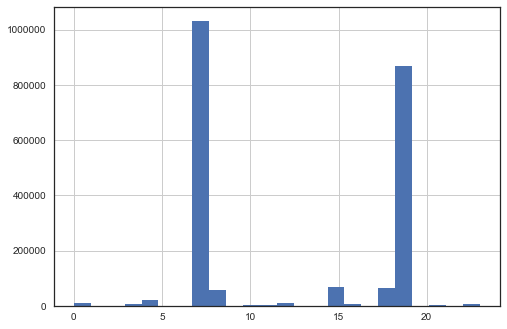

In [51]:
snow = snow[snow.DATE_FIN_PLANIF.notnull()]
snow.DATE_DEB_PLANIF.dt.hour.hist(bins=24)

Get all unique days on and around snow removal operations

In [52]:
snow_days = list(set(np.concatenate((snow.start_buffer.dt.date,
                            snow.end_buffer.dt.date,
                            snow.DATE_DEB_PLANIF.dt.date,
                            snow.DATE_DEB_REPLANIF.dt.date,
                            snow.DATE_FIN_REPLANIF.dt.date))))
# Remove NaN from list
snow_days.pop(0)
print("Number of snow removal days in data: {}".format(len(snow_days)))

Number of snow removal days in data: 210


This is where both datasets are joined on the street side ID.

In [53]:
# Isolate towings that are within 0.00005 decimal degrees of a street boundary, to eliminated any off-street towings
towed = towed[towed.Distance <= 0.00005]

# Isolate tow dates where snow operations took place and join to Planif-Neige data
in_snow_days = towed[towed.DATE_ORIGI.dt.date.isin(snow_days)]
joined = in_snow_days.merge(snow, how='inner', left_on='COT_RUE_ID', right_on='COTE_RUE_ID')

print("Towings in snow removal days: {}".format(len(in_snow_days)))
print("Rows in joined table: {}".format(len(joined)))
joined.head(10)

Towings in snow removal days: 111181
Rows in joined table: 4689266


,ARRONDISSE,COT_RUE_ID,DATE_ORIGI,Distance,ID_TRC,LATITUDE_O,LONGITUDE_,MOTIF_REMO,NOM_VOIE,RUE_ORIGIN,...,COTE_RUE_ID,ETAT_DENEIG,DATE_DEB_PLANIF,DATE_FIN_PLANIF,DATE_DEB_REPLANIF,DATE_FIN_REPLANIF,DATE_MAJ,shift,start_buffer,end_buffer
0,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,2,2016-01-02 18:00:00,2016-01-03 07:00:00,NaT,NaT,2015-12-29 17:26:42,night,2016-01-02 06:00:00,2016-01-03 19:00:00
1,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,4,2016-01-02 18:00:00,2016-01-03 07:00:00,NaT,NaT,2016-01-02 13:08:48,night,2016-01-02 06:00:00,2016-01-03 19:00:00
2,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,3,2016-01-02 18:00:00,2016-01-03 07:00:00,2016-01-04 18:00:00,2016-01-05 07:00:00,2016-01-02 21:46:34,night,2016-01-02 06:00:00,2016-01-03 19:00:00
3,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,3,2016-01-02 18:00:00,2016-01-03 07:00:00,2016-01-03 18:00:00,2016-01-04 07:00:00,2016-01-03 13:52:59,night,2016-01-02 06:00:00,2016-01-03 19:00:00
4,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,1,2016-01-02 18:00:00,2016-01-03 07:00:00,2016-01-03 18:00:00,2016-01-04 07:00:00,2016-01-04 00:23:14,night,2016-01-02 06:00:00,2016-01-03 19:00:00
5,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,2,2016-01-19 18:00:00,2016-01-20 07:00:00,NaT,NaT,2016-01-19 09:03:07,night,2016-01-19 06:00:00,2016-01-20 19:00:00
6,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,1,2016-01-19 18:00:00,2016-01-20 07:00:00,NaT,NaT,2016-01-20 05:21:46,night,2016-01-19 06:00:00,2016-01-20 19:00:00
7,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,2,2016-02-18 18:00:00,2016-02-19 07:00:00,NaT,NaT,2016-02-16 17:22:30,night,2016-02-18 06:00:00,2016-02-19 19:00:00
8,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,2,2016-03-03 18:00:00,2016-03-04 07:00:00,NaT,NaT,2016-03-02 11:05:24,night,2016-03-03 06:00:00,2016-03-04 19:00:00
9,Outremont,16039341,2015-12-31 01:32:00,0.00004,1603934,45.52078,-73.61281,Constat d'infraction,Outremont,avenue Outremont,...,16039341,5,2016-03-03 18:00:00,2016-03-04 07:00:00,NaT,NaT,2016-03-03 23:14:58,night,2016-03-03 06:00:00,2016-03-04 19:00:00


In [54]:
# How many cars were towed outside snow removal days, for comparison

nonsnow = towed[~towed.DATE_ORIGI.dt.date.isin(snow_days)]
print(len(nonsnow))

16328


This is a critical operation. It's where we isolate towings around the restricted hours and see which ones were towed during the restriction (valid tows) our outside (wrongful tows).

In [76]:
around_clearing = joined[(joined.DATE_ORIGI >= joined.start_buffer) & (joined.DATE_ORIGI <= joined.end_buffer)]

# Function to calculate time difference between tows and the start/end of restricted hours.
# If the towing happened before the restriction, calculate time before start.
# If it was after, calculate time after end.
def conditional_filter(row):
    if row.DATE_ORIGI < row.DATE_DEB_PLANIF:
        return row.DATE_DEB_PLANIF - row.DATE_ORIGI
    elif row.DATE_ORIGI > row.DATE_FIN_PLANIF:
        return row.DATE_ORIGI - row.DATE_FIN_PLANIF

around_clearing['time_diff'] = around_clearing.apply(conditional_filter, axis=1)

# If time_diff is NaT, then the towing happened during the restricted hours, and is a valid towing
around_clearing['during_restriction'] = np.where(around_clearing.time_diff.isnull(), True, False)

good_cols = ['UID', 'ARRONDISSE', 'COTE_RUE_ID', 'DATE_ORIGI',
             'DATE_DEB_PLANIF', 'DATE_FIN_PLANIF', 'DATE_DEB_REPLANIF',
             'DATE_FIN_REPLANIF', 'ETAT_DENEIG', 'DATE_MAJ', 'shift', 
             'during_restriction', 'time_diff', 'geometry']

around_clearing = around_clearing[good_cols]
around_clearing.head()

C:\Users\rochar\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rochar\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,UID,ARRONDISSE,COTE_RUE_ID,DATE_ORIGI,DATE_DEB_PLANIF,DATE_FIN_PLANIF,DATE_DEB_REPLANIF,DATE_FIN_REPLANIF,ETAT_DENEIG,DATE_MAJ,shift,during_restriction,time_diff,geometry
133,5911,Outremont,16039341,2016-01-19 21:11:00,2016-01-19 18:00:00,2016-01-20 07:00:00,NaT,NaT,2,2016-01-19 09:03:07,night,True,NaT,POINT (-73.6130858226 45.5209035481)
134,5911,Outremont,16039341,2016-01-19 21:11:00,2016-01-19 18:00:00,2016-01-20 07:00:00,NaT,NaT,1,2016-01-20 05:21:46,night,True,NaT,POINT (-73.6130858226 45.5209035481)
204,89052,Sud-Ouest,16003101,2017-12-15 09:38:00,2017-12-15 19:00:00,2017-12-16 07:00:00,NaT,NaT,2,2017-12-15 07:07:37,night,False,09:22:00,POINT (-73.59318775369999 45.4481261562)
262,103718,Sud-Ouest,16003101,2018-01-10 08:41:00,2018-01-10 07:00:00,2018-01-10 19:00:00,NaT,NaT,5,2018-01-10 14:21:27,morning,True,NaT,POINT (-73.5933433922 45.4480920724)
294,124677,Sud-Ouest,16003101,2018-02-12 09:03:00,2018-02-12 07:00:00,2018-02-12 19:00:00,NaT,NaT,2,2018-02-11 12:50:24,morning,True,NaT,POINT (-73.593872336 45.4480087784)


Count how many of these tows were done during the posted Info-Neige restriction hours (True) and outside(False)

In [77]:
around_clearing.drop_duplicates('UID').during_restriction.value_counts()

True     60475
False     7733
Name: during_restriction, dtype: int64

It's not guaranteed that the towing records were assigned to the right street side. We need to do a final check by looking at the clearning schedules of opposite side in the Planif-Neige data.

In [78]:
finalists = around_clearing[around_clearing.during_restriction == False]

# Create a column of the opposite street side ID
def opposite_side(row):
    side_num = row.COTE_RUE_ID[-1]
    if side_num == '1':
        return row.COTE_RUE_ID[:-1] + '2'
    else:
        return row.COTE_RUE_ID[:-1] + '1'
    
finalists['opposite_side'] = finalists.apply(opposite_side, axis=1)

check_df = finalists[['UID', 'COTE_RUE_ID', 'DATE_ORIGI', 'opposite_side']]
check_df = check_df.merge(snow, how='inner', left_on='opposite_side', right_on = 'COTE_RUE_ID')
check_UID = check_df[(check_df.DATE_ORIGI >= check_df.DATE_DEB_PLANIF) & (check_df.DATE_ORIGI <= check_df.DATE_FIN_PLANIF)].UID.unique()
print("Number of towings inside opposite street side hours: {}".format(len(check_UID)))

C:\Users\rochar\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of towings inside opposite street side hours: 4679


These are a lot of potential false positives. We need to remove these from the finalists table.

In [79]:
bad_tows = finalists[~finalists.UID.isin(check_UID)].drop_duplicates('UID', keep='last')
print(len(bad_tows.UID.unique()))
bad_tows.head(10)

3138


,UID,ARRONDISSE,COTE_RUE_ID,DATE_ORIGI,DATE_DEB_PLANIF,DATE_FIN_PLANIF,DATE_DEB_REPLANIF,DATE_FIN_REPLANIF,ETAT_DENEIG,DATE_MAJ,shift,during_restriction,time_diff,geometry,opposite_side
2376,13,Villeray - Saint-Michel - Parc-Extension,10704222,2015-12-30 07:21:00,2015-12-30 19:00:00,2015-12-31 07:00:00,NaT,NaT,2,2015-12-30 12:43:12,night,False,11:39:00,POINT (-73.6134731328 45.5654383474),10704221
2483,14,Saint-Léonard,16115142,2015-12-30 07:37:00,2015-12-30 15:00:00,2015-12-31 07:00:00,NaT,NaT,1,2015-12-31 03:00:36,night,False,07:23:00,POINT (-73.61302040130001 45.5975020593),16115141
5410,102699,Rosemont - La Petite-Patrie,11403291,2018-01-14 12:15:00,2018-01-14 23:59:59,2018-01-15 07:00:00,NaT,NaT,5,2018-01-15 01:38:39,night,False,11:44:59,POINT (-73.6015047958 45.535416938),11403292
5442,24,Rivière-des-Prairies - Pointe-aux-Trembles,16246461,2015-12-30 09:11:00,2015-12-30 19:00:00,2015-12-31 07:00:00,NaT,NaT,1,2015-12-31 04:09:31,night,False,09:49:00,POINT (-73.5713938737 45.6422342487),16246462
8185,112665,Rivière-des-Prairies - Pointe-aux-Trembles,14802951,2018-02-06 09:13:00,2018-02-05 19:00:00,2018-02-06 07:00:00,NaT,NaT,2,2018-02-05 17:37:01,night,False,02:13:00,POINT (-73.60384732270001 45.6353143909),14802952
8316,122586,Rivière-des-Prairies - Pointe-aux-Trembles,14802951,2018-02-13 08:14:00,2018-02-12 19:00:00,2018-02-13 07:00:00,NaT,NaT,5,2018-02-13 01:18:09,night,False,01:14:00,POINT (-73.6053298822 45.6367861022),14802952
8741,43,Côte-des-Neiges - Notre-Dame-de-Grâce,13002732,2015-12-31 02:14:00,2015-12-30 07:00:00,2015-12-30 19:00:00,NaT,NaT,1,2015-12-31 14:44:20,morning,False,07:14:00,POINT (-73.6322474893 45.486848684),13002731
8787,44,Côte-des-Neiges - Notre-Dame-de-Grâce,13002732,2015-12-31 02:20:00,2015-12-30 07:00:00,2015-12-30 19:00:00,NaT,NaT,1,2015-12-31 14:44:20,morning,False,07:20:00,POINT (-73.6320269201 45.4870669705),13002731
10298,5432,Outremont,16039871,2015-12-31 07:12:00,2015-12-30 18:00:00,2015-12-31 07:00:00,NaT,NaT,1,2015-12-30 22:15:54,night,False,00:12:00,POINT (-73.6108263086 45.5185496899),16039872
13554,67,Verdun,16015071,2015-12-30 09:49:00,2015-12-30 04:00:00,2015-12-30 09:00:00,NaT,NaT,1,2015-12-30 17:07:09,morning,False,00:49:00,POINT (-73.57698439409999 45.4489800698),16015072


Let's do one last final sanity check: let's see if the number of towings aorund snow removal hours is in line with towings on all other days.

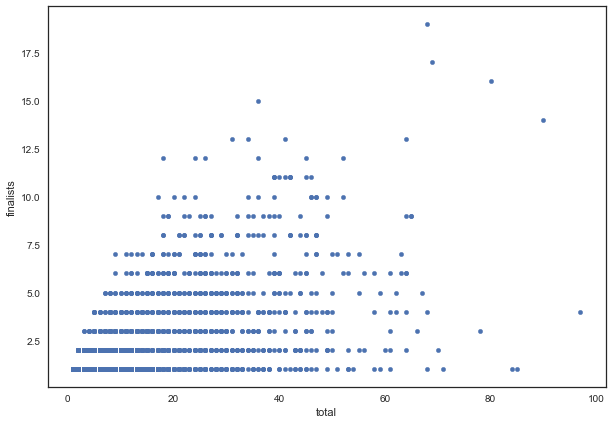

In [80]:
# Number of towings on each street segment among finalists vs. all towings

final_tow_counts = finalists.drop_duplicates('UID').COTE_RUE_ID.str.slice(0,-1).value_counts()
total_tow_counts = towed.ID_TRC.value_counts()
comparison = (pd.concat([total_tow_counts, final_tow_counts], axis=1)
 .dropna()
 .rename(columns = {'ID_TRC':'total', 'COTE_RUE_ID':'finalists'})
 .sort_values('finalists', ascending=False)
)
comparison.plot.scatter(x = 'total', y='finalists', figsize = (10, 7))

Some interesting outliers. Where are they?

In [81]:
max_segments = comparison.finalists.nlargest(2).index
bad_tows[(bad_tows.COTE_RUE_ID.str.startswith(max_segments[0])) | (bad_tows.COTE_RUE_ID.str.startswith(max_segments[1]))]

,UID,ARRONDISSE,COTE_RUE_ID,DATE_ORIGI,DATE_DEB_PLANIF,DATE_FIN_PLANIF,DATE_DEB_REPLANIF,DATE_FIN_REPLANIF,ETAT_DENEIG,DATE_MAJ,shift,during_restriction,time_diff,geometry,opposite_side
160070,48784,Ville-Marie,40087481,2017-01-05 21:14:00,2017-01-05 07:00:00,2017-01-05 19:00:00,NaT,NaT,2,2017-01-05 10:48:21,morning,False,02:14:00,POINT (-73.56124540250001 45.5256801705),40087482
161813,95369,Ville-Marie,40087481,2018-01-09 21:45:00,2018-01-09 07:00:00,2018-01-09 19:00:00,NaT,NaT,2,2018-01-09 00:41:44,morning,False,02:45:00,POINT (-73.5601617512 45.525211023),40087482
161957,95888,Ville-Marie,40087481,2018-01-09 21:30:00,2018-01-09 07:00:00,2018-01-09 19:00:00,NaT,NaT,2,2018-01-09 00:41:44,morning,False,02:30:00,POINT (-73.5618355192 45.525914364),40087482
259388,1053,Ville-Marie,13805681,2016-01-03 09:26:00,2016-01-03 19:00:00,2016-01-04 07:00:00,NaT,NaT,1,2016-01-04 16:29:34,night,False,09:34:00,POINT (-73.56495668549999 45.52235106),13805682
259429,2112,Ville-Marie,13805681,2016-01-03 09:56:00,2016-01-03 19:00:00,2016-01-04 07:00:00,NaT,NaT,1,2016-01-04 16:29:34,night,False,09:04:00,POINT (-73.5626227507 45.5212545897),13805682
259470,3167,Ville-Marie,13805681,2016-01-03 09:10:00,2016-01-03 19:00:00,2016-01-04 07:00:00,NaT,NaT,1,2016-01-04 16:29:34,night,False,09:50:00,POINT (-73.5652311441 45.5224631486),13805682
259511,3168,Ville-Marie,13805681,2016-01-03 09:54:00,2016-01-03 19:00:00,2016-01-04 07:00:00,NaT,NaT,1,2016-01-04 16:29:34,night,False,09:06:00,POINT (-73.5648728553 45.5223009678),13805682
259552,3169,Ville-Marie,13805681,2016-01-03 10:46:00,2016-01-03 19:00:00,2016-01-04 07:00:00,NaT,NaT,1,2016-01-04 16:29:34,night,False,08:14:00,POINT (-73.5651501234 45.5224243278),13805682
259596,7428,Ville-Marie,13805681,2016-01-21 15:14:00,2016-01-20 19:00:00,2016-01-21 07:00:00,NaT,NaT,1,2016-01-21 06:03:30,night,False,08:14:00,POINT (-73.5626338037 45.5212607887),13805682
259637,7429,Ville-Marie,13805681,2016-01-21 14:43:00,2016-01-20 19:00:00,2016-01-21 07:00:00,NaT,NaT,1,2016-01-21 06:03:30,night,False,07:43:00,POINT (-73.5651332458 45.5224085911),13805682


Some towings happend just minutes after the posted end of operations. Let's add a 15-minute grace period for those that went a little over time.

In [82]:
bad_tows = bad_tows[bad_tows.time_diff > pd.Timedelta(minutes=15)]
len(bad_tows)

2993

Compare this to the number of towings inside the restricted hours

In [83]:
len(around_clearing[around_clearing.during_restriction].UID.unique())

60659

So the bad towings are about 5% of all examined towings.

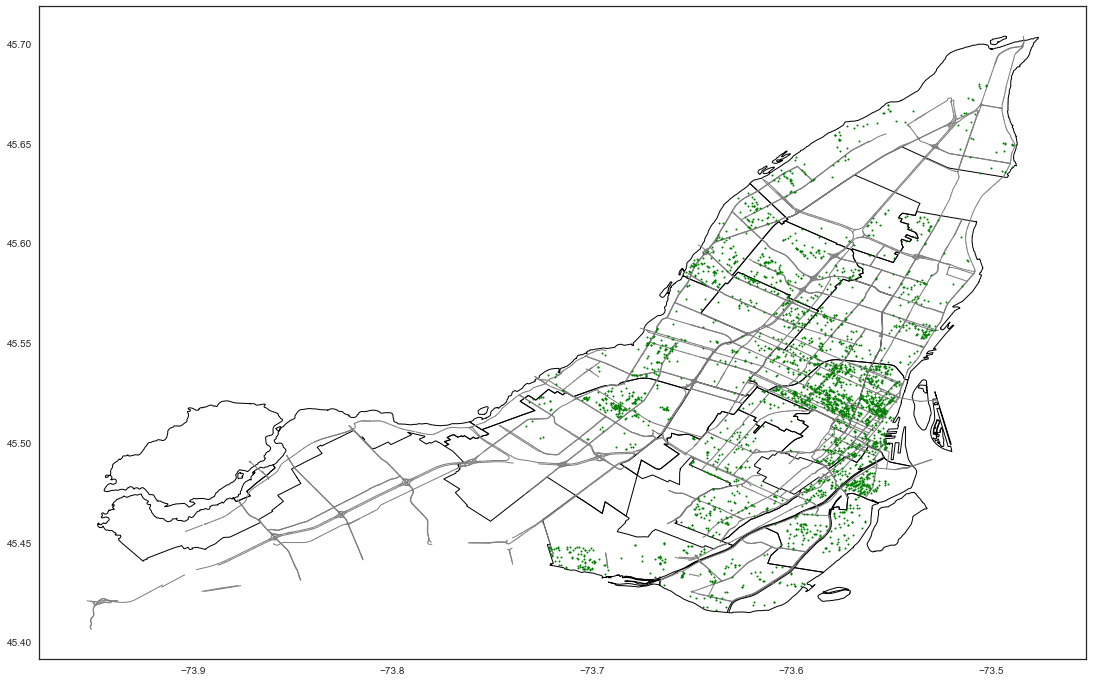

In [84]:
# Map the bad ones
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
basemap = geopandas.read_file('../../Map files/Montreal/Boroughs/montreal_boroughs.shp')
arteries = geopandas.read_file('../../Map files/Montreal/geobasemtlshp/GEOBASE_MTL_arteries.shp')

fig, ax = plt.subplots(figsize = (20,12))
ax.set_aspect('equal')

basemap.plot(ax=ax, color='white', edgecolor='black')
arteries.plot(ax=ax, color='grey')
bad_tows.plot(ax=ax, color='green')

plt.show()

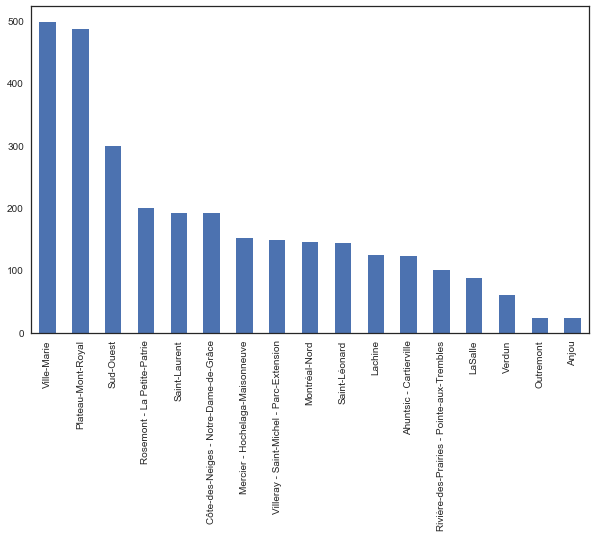

In [85]:
# Number of suspicious towing per borough

bad_tows.ARRONDISSE.value_counts().plot.bar(figsize=(10,6))

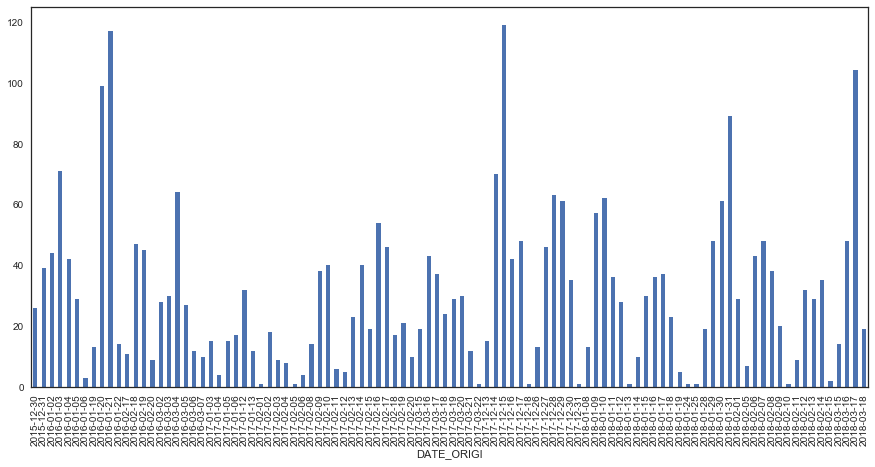

In [86]:
# When the suspicious tows took place

tows_by_date = bad_tows.groupby(bad_tows.DATE_ORIGI.dt.date).size()
tows_by_date.plot.bar(figsize=(15,7))

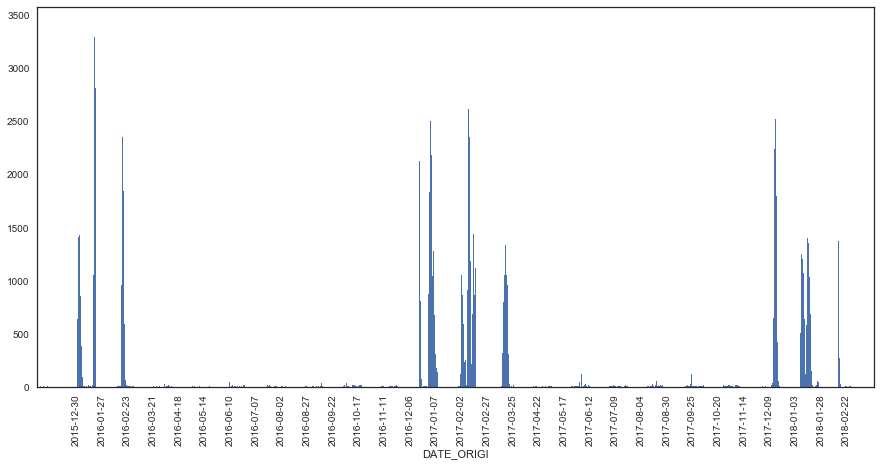

In [87]:
# Compare it with overall tows
# The frequecy should be proportional to overall tows

first_day = tows_by_date.index[0].isoformat()
last_day = tows_by_date.index[-1].isoformat()
all_tows_by_date = towed.groupby(towed.DATE_ORIGI.dt.date).size()

fig, ax = plt.subplots(figsize=(15,7))
all_tows_by_date.plot.bar()
labels = ax.get_xticklabels()
for tick in labels:
    if tick.get_text() == first_day:
        tick_index1 = labels.index(tick)
    if tick.get_text() == last_day:
        tick_index2 = labels.index(tick)
        
tick_pos = ax.get_xticks()
ax.set_xticklabels(ax.get_xticklabels()[tick_index1:tick_index2:25])
ax.set_xticks(tick_pos[tick_index1:tick_index2:25])

See if there are patterns in the hour of towing acorss boroughs. Colour by morning/night snow removal period.

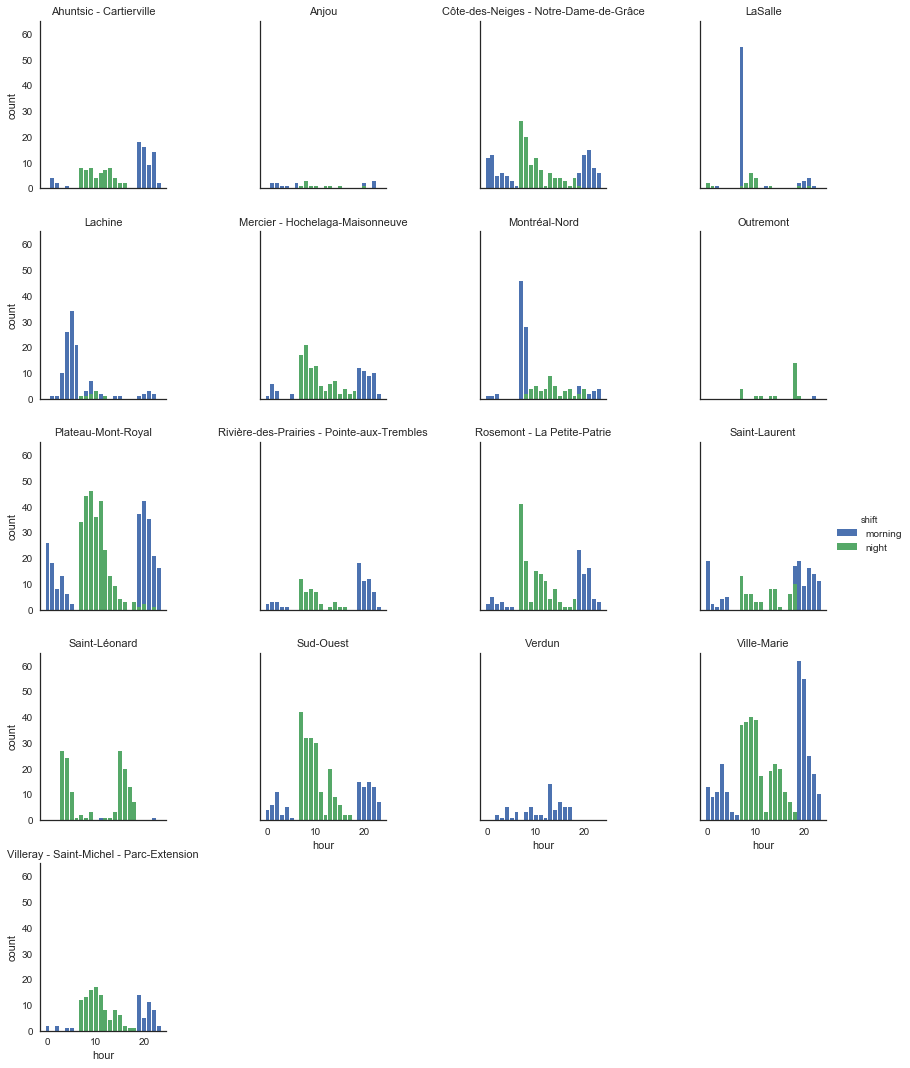

In [88]:
borough_time = (bad_tows.groupby(['ARRONDISSE', 'shift', bad_tows.DATE_ORIGI.dt.hour])
                .count()['UID']
                .reset_index()
                .rename(columns = {'DATE_ORIGI':'hour', 'UID':'count'})
               )

g = sns.FacetGrid(borough_time, col = 'ARRONDISSE', hue='shift', col_wrap = 4)
g.map(plt.bar, 'hour', 'count' ).set_titles('{col_name}').add_legend()

That's an interesting peak in LaSalle. Inspecting the data shows the most towings outside snow removal times happen in the 7-8 am hour.

In [89]:
borough_time.query('ARRONDISSE == "LaSalle"')

,ARRONDISSE,shift,hour,count
58,LaSalle,morning,0,1
59,LaSalle,morning,2,1
60,LaSalle,morning,7,55
61,LaSalle,morning,12,1
62,LaSalle,morning,19,2
63,LaSalle,morning,20,3
64,LaSalle,morning,21,4
65,LaSalle,morning,22,1
66,LaSalle,night,0,2
67,LaSalle,night,1,1


In [90]:
# Map the finalists in folium

from folium import Map, CircleMarker, Popup

def plot_tows(df):
    time_format = '%b %d, %Y %H:%M'
    mapa = Map(location = [45.6, -73.5], tiles = 'cartodbpositron' )

    for i, row in df.iterrows():
        CircleMarker(location = [row.geometry.y , row.geometry.x],
                     radius = 3,
                     color = None,
                     fill = True,
                     fill_color = 'blue',
                     popup = Popup('Tow: ' 
                                   + row['DATE_ORIGI'].strftime(time_format) 
                                   + '<br>Restriction period: ' 
                                   + row['DATE_DEB_PLANIF'].strftime('%H')
                                   + ' - ' + row['DATE_FIN_PLANIF'].strftime('%H')),
                     fill_opacity = 0.6  
                    ).add_to(mapa)
    return mapa

plot_tows(bad_tows).save('bad_tows.html')

In [91]:
# Export CSV of good vs. bad towings to visualize outside Python

good_tows = around_clearing[around_clearing.during_restriction == True]
all_tows = pd.concat([good_tows, bad_tows])
all_tows.drop_duplicates('UID').to_csv('output/montreal_tows.csv', index=False)

These are the tow IDs from reader submissions. Check them in the data within 7 days before and after the Info-Neige hours

In [92]:
ids = [str(n) for n in [90599,131493,100997,112426,86970,126201,80384,105723,98937,123934,129351,129242,126914]]

reader_tows = (joined[(joined.UID.isin(ids))
      & (joined.DATE_ORIGI >= joined.DATE_DEB_PLANIF - pd.DateOffset(days=10))
      & (joined.DATE_ORIGI <= joined.DATE_FIN_PLANIF + pd.DateOffset(days=10))]
.drop_duplicates('UID'))

reader_tows['during_restriction'] = np.where((reader_tows.DATE_ORIGI >= reader_tows.DATE_DEB_PLANIF) 
                                             & (reader_tows.DATE_ORIGI <= reader_tows.DATE_FIN_PLANIF) , True, False)

good_cols = ['UID', 'ARRONDISSE', 'COTE_RUE_ID', 'DATE_ORIGI',
             'DATE_DEB_PLANIF', 'DATE_FIN_PLANIF', 'during_restriction' , 'geometry']

reader_tows[good_cols]

,UID,ARRONDISSE,COTE_RUE_ID,DATE_ORIGI,DATE_DEB_PLANIF,DATE_FIN_PLANIF,during_restriction,geometry
350249,80384,Lachine,16050412,2017-12-16 16:12:00,2017-12-16 07:00:00,2017-12-16 19:00:00,True,POINT (-73.6994533853 45.4359714658)
640136,105723,Plateau-Mont-Royal,12500181,2018-01-30 12:04:00,2018-01-29 07:00:00,2018-01-29 19:00:00,False,POINT (-73.5763199372 45.5175479122)
960615,126201,Sud-Ouest,13602472,2018-03-17 04:49:00,2018-03-16 19:00:00,2018-03-17 07:00:00,True,POINT (-73.5925935467 45.4766740797)
1006533,126914,Côte-des-Neiges - Notre-Dame-de-Grâce,12911342,2018-03-17 02:40:00,2018-03-15 19:00:00,2018-03-16 07:00:00,False,POINT (-73.6344872505 45.4978100441)
1811178,131493,Côte-des-Neiges - Notre-Dame-de-Grâce,13002611,2018-03-18 02:47:00,2018-03-17 19:00:00,2018-03-18 07:00:00,True,POINT (-73.6225952715 45.4822044792)
2138875,123934,Plateau-Mont-Royal,12401572,2018-03-17 11:34:00,2018-03-17 07:00:00,2018-03-17 19:00:00,True,POINT (-73.590194408 45.5257087911)
2990557,129351,Sud-Ouest,13604241,2018-03-16 10:56:00,2018-03-17 07:00:00,2018-03-17 19:00:00,False,POINT (-73.5820736558 45.4782125047)
3437292,90599,LaSalle,16065161,2017-12-18 07:10:00,2017-12-13 19:00:00,2017-12-14 07:00:00,False,POINT (-73.61537017409999 45.4186010756)
3966025,100997,Ville-Marie,13808052,2018-01-08 21:06:00,2018-01-08 19:00:00,2018-01-09 07:00:00,True,POINT (-73.5510173469 45.5202639988)
4153098,129242,Ahuntsic - Cartierville,16251992,2018-03-15 22:31:00,2018-03-15 19:00:00,2018-03-16 07:00:00,True,POINT (-73.6453085126 45.5427265779)


### Tows after operations ended

We also looked at cars that were towed even though Info-Neige signalled that snow removal operations were over. There weren't many.

Officially, cars aren't allowed to park until the orange signs go down. In the case where Info-Neige and the orange signs contadict each other, the orange signs take precedence.

Usually, a street is signalled as clear one hour after the plows go through to allow time for a second pass if needed.

In [93]:
# Calculate average time from when the first alert goes out and the start of snow removal operations

alert_time = snow[snow.ETAT_DENEIG == '2'].drop_duplicates('COTE_RUE_ID', keep='first')
alert_time['alert_diff'] = alert_time.DATE_DEB_PLANIF - alert_time.DATE_MAJ
print("Overall avg. advance alert: {}".format(alert_time.alert_diff.mean()))

Overall avg. advance alert: 0 days 13:55:47.925024


14 hours is a lot of time. The city aims for a 6-hour notice for night operations and 10 hours for morning operations.

In [98]:
# We want to see tows after the operation ended, but still inside planned hours
# Codes 1 and 10 in Planif-Neige mean the snow has been cleared
# This filters towings after a code 1 or 10 was published

cols = ['UID', 'ARRONDISSE', 'COTE_RUE_ID', 'DATE_ORIGI',
        'DATE_DEB_PLANIF', 'DATE_FIN_PLANIF', 'ETAT_DENEIG', 'DATE_MAJ', 'geometry']

after_end = ( joined[(joined.ETAT_DENEIG.isin(['1', '10']))
                   & (joined.DATE_ORIGI < joined.DATE_FIN_PLANIF)
                   & (joined.DATE_ORIGI > joined.DATE_MAJ) 
                   & (joined.DATE_MAJ > joined.DATE_DEB_PLANIF) ])[cols]
after_end['time_after_alert'] = after_end.DATE_ORIGI - after_end.DATE_MAJ
print("Number of tows: {}".format(len(after_end.UID.unique())))
print("Average time after operations end alert: {}".format(after_end.time_after_alert.mean()))
after_end.head(15)

Number of tows: 133
Average time after operations end alert: 0 days 01:28:50.045112


,UID,ARRONDISSE,COTE_RUE_ID,DATE_ORIGI,DATE_DEB_PLANIF,DATE_FIN_PLANIF,ETAT_DENEIG,DATE_MAJ,geometry,time_after_alert
10246,55,Outremont,16039871,2015-12-31 01:09:00,2015-12-30 18:00:00,2015-12-31 07:00:00,1,2015-12-30 22:15:54,POINT (-73.61082167479999 45.5185495192),02:53:06
10272,629,Outremont,16039871,2015-12-30 22:45:00,2015-12-30 18:00:00,2015-12-31 07:00:00,1,2015-12-30 22:15:54,POINT (-73.6108506857 45.5185648702),00:29:06
125288,464,Outremont,16039352,2015-12-31 00:38:00,2015-12-30 18:00:00,2015-12-31 07:00:00,1,2015-12-31 00:34:57,POINT (-73.6121898759 45.5203830948),00:03:03
132820,499,Outremont,16038582,2015-12-31 00:25:00,2015-12-30 18:00:00,2015-12-31 07:00:00,1,2015-12-30 23:12:46,POINT (-73.6208240152 45.5166751792),01:12:14
138098,8493,Côte-des-Neiges - Notre-Dame-de-Grâce,12700541,2016-01-20 22:55:00,2016-01-20 19:00:00,2016-01-21 07:00:00,1,2016-01-20 22:29:20,POINT (-73.6209593175 45.4957361945),00:25:40
180784,704,Sud-Ouest,13501411,2016-01-02 13:49:00,2016-01-02 07:00:00,2016-01-02 19:00:00,1,2016-01-02 13:18:48,POINT (-73.5927382955 45.4595039437),00:30:12
246240,1532,Outremont,16040772,2015-12-31 03:54:00,2015-12-30 18:00:00,2015-12-31 07:00:00,1,2015-12-31 00:56:48,POINT (-73.59864618819999 45.5191198607),02:57:12
246263,4206,Outremont,16040772,2015-12-31 06:11:00,2015-12-30 18:00:00,2015-12-31 07:00:00,1,2015-12-31 00:56:48,POINT (-73.59866540199999 45.5191024673),05:14:12
253549,1031,Plateau-Mont-Royal,12101171,2015-12-30 15:20:00,2015-12-30 07:00:00,2015-12-30 19:00:00,1,2015-12-30 12:31:48,POINT (-73.5617882432 45.5369446694),02:48:12
277653,1111,Anjou,16142232,2015-12-30 18:54:00,2015-12-30 07:00:00,2015-12-30 19:00:00,1,2015-12-30 17:53:02,POINT (-73.5488859985 45.6117338981),01:00:58


### Tows where Info-Neige hours changed

In some cases, cars were towed outside the posted Info-Neige hours, but the schedule was changed the following day. This makes it look like the towing was valid and inside the restricted hours.

In [103]:
# Get street segments that had more than one scheduled time in one day

changed_times_cotes = ( snow.assign(hour = snow.DATE_DEB_PLANIF.dt.hour)
                       .groupby(['COTE_RUE_ID', snow.DATE_DEB_PLANIF.dt.date]).hour.nunique()
                       .to_frame()
                       .query('hour > 1')
                       .index.unique()
                       .astype(object)
                      )
print("Number of schedule changes for all street segments: {}".format(len(changed_times_cotes)))
print("Total number of snow removal schedules: {}".format(len(snow.drop_duplicates(['COTE_RUE_ID', 'DATE_DEB_PLANIF']))))

Number of schedule changes for all street segments: 5537
Total number of snow removal schedules: 890131


Changed schedules are less than 1% of all schedules.

In [100]:
# Isolate the street sides that had a schedule change

changed_times_all = ( snow[snow.set_index(['COTE_RUE_ID', snow.DATE_DEB_PLANIF.dt.date]).index.isin(changed_times_cotes)]
 .drop_duplicates(['COTE_RUE_ID', 'DATE_DEB_PLANIF'])
 .sort_values(['COTE_RUE_ID', 'DATE_DEB_PLANIF']))
changed_times_all.head(10)

,MUNID,COTE_RUE_ID,ETAT_DENEIG,DATE_DEB_PLANIF,DATE_FIN_PLANIF,DATE_DEB_REPLANIF,DATE_FIN_REPLANIF,DATE_MAJ,shift,start_buffer,end_buffer
281413,66023,10102381,2,2015-12-30 07:00:00,2015-12-30 19:00:00,NaT,NaT,2015-12-29 19:12:58,morning,2015-12-29 19:00:00,2015-12-31 07:00:00
1330913,66023,10102381,2,2015-12-30 19:00:00,2015-12-31 07:00:00,NaT,NaT,2015-12-30 11:47:55,night,2015-12-30 07:00:00,2015-12-31 19:00:00
103568,66023,10110012,2,2017-12-13 18:00:00,2017-12-14 07:00:00,NaT,NaT,2017-12-13 09:43:41,night,2017-12-13 06:00:00,2017-12-14 19:00:00
105013,66023,10110012,2,2017-12-13 19:00:00,2017-12-14 07:00:00,NaT,NaT,2017-12-13 10:01:08,night,2017-12-13 07:00:00,2017-12-14 19:00:00
744425,66023,10110012,2,2018-01-08 18:00:00,2018-01-09 07:00:00,NaT,NaT,2018-01-08 14:50:29,night,2018-01-08 06:00:00,2018-01-09 19:00:00
744932,66023,10110012,2,2018-01-08 19:00:00,2018-01-09 07:00:00,NaT,NaT,2018-01-08 15:24:57,night,2018-01-08 07:00:00,2018-01-09 19:00:00
987521,66023,10200761,2,2017-02-17 07:00:00,2017-02-17 19:00:00,NaT,NaT,2017-02-16 00:00:00,morning,2017-02-16 19:00:00,2017-02-18 07:00:00
1037441,66023,10200761,2,2017-02-17 19:00:00,2017-02-18 07:00:00,NaT,NaT,2017-02-17 18:23:35,night,2017-02-17 07:00:00,2017-02-18 19:00:00
987522,66023,10200781,2,2017-02-17 07:00:00,2017-02-17 19:00:00,NaT,NaT,2017-02-16 00:00:00,morning,2017-02-16 19:00:00,2017-02-18 07:00:00
1037442,66023,10200781,2,2017-02-17 19:00:00,2017-02-18 07:00:00,NaT,NaT,2017-02-17 18:23:35,night,2017-02-17 07:00:00,2017-02-18 19:00:00


In [102]:
# Join it to towings data

changed_times = towed.merge(changed_times_all, left_on='COT_RUE_ID', right_on='COTE_RUE_ID', how='inner')

changed_time_tows = changed_times[(changed_times.DATE_ORIGI >= changed_times.DATE_DEB_PLANIF) 
             &(changed_times.DATE_ORIGI <= changed_times.DATE_FIN_PLANIF) ].UID.unique()
changed_times = changed_times[changed_times.UID.isin(changed_time_tows)][cols]
print("Number of towings in segments that changed schedules: {}".format(len(changed_times.UID.unique())))
changed_times.head(12)

Number of towings in segments that changed schedules: 355


,UID,ARRONDISSE,COTE_RUE_ID,DATE_ORIGI,DATE_DEB_PLANIF,DATE_FIN_PLANIF,ETAT_DENEIG,DATE_MAJ,geometry
0,13,Villeray - Saint-Michel - Parc-Extension,10704222,2015-12-30 07:21:00,2015-12-30 07:00:00,2015-12-30 19:00:00,2,2015-12-31 06:15:49,POINT (-73.6134731328 45.5654383474)
1,13,Villeray - Saint-Michel - Parc-Extension,10704222,2015-12-30 07:21:00,2015-12-30 19:00:00,2015-12-31 07:00:00,2,2015-12-30 12:43:12,POINT (-73.6134731328 45.5654383474)
88,43,Côte-des-Neiges - Notre-Dame-de-Grâce,13002732,2015-12-31 02:14:00,2015-12-30 07:00:00,2015-12-30 19:00:00,2,2015-12-31 09:07:22,POINT (-73.6322474893 45.486848684)
89,43,Côte-des-Neiges - Notre-Dame-de-Grâce,13002732,2015-12-31 02:14:00,2015-12-30 19:00:00,2015-12-31 07:00:00,2,2015-12-30 09:27:18,POINT (-73.6322474893 45.486848684)
90,44,Côte-des-Neiges - Notre-Dame-de-Grâce,13002732,2015-12-31 02:20:00,2015-12-30 07:00:00,2015-12-30 19:00:00,2,2015-12-31 09:07:22,POINT (-73.6320269201 45.4870669705)
91,44,Côte-des-Neiges - Notre-Dame-de-Grâce,13002732,2015-12-31 02:20:00,2015-12-30 19:00:00,2015-12-31 07:00:00,2,2015-12-30 09:27:18,POINT (-73.6320269201 45.4870669705)
126,95391,Plateau-Mont-Royal,12210092,2018-01-09 00:09:00,2018-01-08 19:00:00,2018-01-09 07:00:00,2,2018-01-08 10:38:37,POINT (-73.5680738697 45.5171371129)
127,95391,Plateau-Mont-Royal,12210092,2018-01-09 00:09:00,2018-01-08 23:59:59,2018-01-09 07:00:00,2,2018-01-08 10:39:47,POINT (-73.5680738697 45.5171371129)
128,68,Plateau-Mont-Royal,12503822,2015-12-31 02:09:00,2015-12-30 00:00:00,2015-12-30 07:00:00,3,2015-12-29 18:45:24,POINT (-73.57929353670001 45.5168956673)
129,68,Plateau-Mont-Royal,12503822,2015-12-31 02:09:00,2015-12-30 19:00:00,2015-12-31 07:00:00,2,2015-12-29 17:56:53,POINT (-73.57929353670001 45.5168956673)
